In [1]:
import urllib
from bs4 import BeautifulSoup

import pandas as pd
import datetime
import csv

import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
class PER:
    def __init__(self,code):
        self.code=code

    def quarterdata(self):
        url="https://kabutan.jp/stock/finance?code={}".format(self.code)
        html=urllib.request.urlopen(url)
        soup=BeautifulSoup(html.read(),"html")

        div=soup.findAll("div",{"class":"fin_q_t0_d fin_q_t1_d"})
        table=div[0].find_all("table")
        tbody=table[0].find_all("tbody")
        td=table[0].find_all("td")

        tdlist=[]
        for i in td:
            text=i.text
            text_str=text.replace(",","")
            try:
                text_int=float(text_str)
                tdlist.append(text_int)
            except:
                tdlist.append(text_str)
        del tdlist[0]
        del tdlist[-1]

        date=[]
        sa=[]
        op=[]
        np=[]
        eps=[]
        for i in range(int(len(tdlist)/7-1)):
            date.append(tdlist[7*i+6])
            sa.append(tdlist[7*i+0])
            op.append(tdlist[7*i+1])
            np.append(tdlist[7*i+3])
            eps.append(tdlist[7*i+4])
        qdata=pd.DataFrame([date,sa,op,np,eps]).T
        qdata.columns=["日付","売上高","営業利益","純利益","EPS"]

        date2=[]
        sa2=[]
        op2=[]
        np2=[]
        eps2=[]
        for i in range(len(qdata)-3):
            date2.append(qdata.iat[3+i,0])
            sa2.append(sum(qdata.iloc[i:i+4,1]))
            op2.append(sum(qdata.iloc[i:i+4,2]))
            np2.append(sum(qdata.iloc[i:i+4,3]))
            eps2.append(sum(qdata.iloc[i:i+4,4]))
        qdata2=pd.DataFrame([date2,sa2,op2,np2,eps2]).T
        qdata2.columns=["日付","売上高","営業利益","純利益","EPS"]
    
        self.qdata=qdata
        self.qdata2=qdata2
    
    def pricedata(self):
        date=[]
        price=[]

        for j in range(2):
            url="https://kabutan.jp/stock/kabuka?code={}&ashi=wek&page={}".format(self.code,j+1)
            html=urllib.request.urlopen(url)
            soup=BeautifulSoup(html.read(),"html")

            table=soup.findAll("table",{"class":"stock_kabuka_dwm"})
            tbody=table[0].find_all("tbody")
            tr=tbody[0].find_all("tr")

            trlist=[]
            for i in tr:
                text=i.text
                text_str=text.replace(",","")
                try:
                    text_int=float(text_str)
                    trlist.append(text_int)
                except:
                    trlist.append(text_str)

            for i in trlist:
                pricelist=i.split("\n")
                date.append(pricelist[1])
                price.append(float(pricelist[5]))

        pdata=pd.DataFrame([date,price]).T
        pdata.columns=["日付","株価"]

        self.pdata=pdata
        
    def indexpricedata(self):
        index=[]
        for j in range(2):
            url="https://kabutan.jp/stock/kabuka?code=0000&ashi=wek&page={}".format(j+1)
            html=urllib.request.urlopen(url)
            soup=BeautifulSoup(html.read(),"html")

            table=soup.findAll("table",{"class":"stock_kabuka_dwm"})
            tbody=table[0].find_all("tbody")
            tr=tbody[0].find_all("tr")
            td=[]
            for i in tr:
                td.append(i.find_all("td"))
            for i in td:
                index.append(float((i[3].text.replace(",",""))))

        self.index=index
    
    def main(self):
        self.quarterdata()
        self.pricedata()
        self.indexpricedata()
        
        data=self.pdata
        data["日経平均"]=self.index
        data["売上高"]=0
        data["営業利益"]=0
        data["純利益"]=0
        data["EPS"]=0

        q=1
        for i in range(len(data)):
            try:  
                ptime=datetime.datetime.strptime(data.iat[i,0],"%y/%m/%d")
                qtime=datetime.datetime.strptime(self.qdata2.iat[-q,0],"%y/%m/%d")
                if ptime<qtime:
                    q=q+1
                sa=self.qdata2.iat[-q,1]
                op=self.qdata2.iat[-q,2]
                np=self.qdata2.iat[-q,3]
                eps=self.qdata2.iat[-q,4]
                data.at[i,"売上高"]=sa
                data.at[i,"営業利益"]=op
                data.at[i,"純利益"]=np
                data.at[i,"EPS"]=eps
            except:
                data=data.iloc[0:-1]
                
        data["PER"]=data["株価"]/data["営業利益"]
        data["PER/Index"]=data["PER"]/data["日経平均"]*10000
        self.data=data
        
        time=[]
        for i in range(len(data)):
            time.append(datetime.datetime.strptime(data.at[i,"日付"],"%y/%m/%d"))
        
        
        fig=plt.figure(figsize=(13,4))
        
        ax1=fig.add_subplot(1,2,1)
        ax2=ax1.twinx()
        ax1.plot(time,data["株価"],color="r")
        ax2.plot(time,data["EPS"],color="b")
        
        ax3=fig.add_subplot(1,2,2)
        ax4=ax3.twinx()
        ax3.plot(time,data["PER"],color="b")
        ax4.plot(time,data["PER/Index"],color="r")
        plt.show()

C:\Users\ShIzm\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


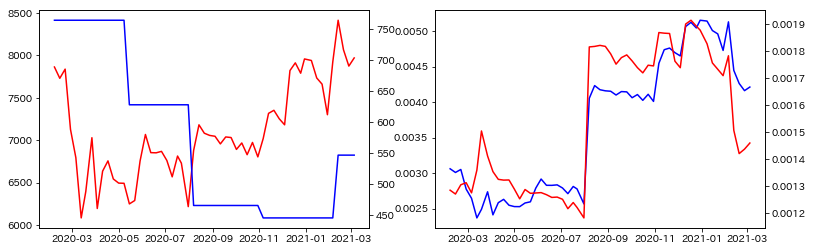

In [3]:
a=PER(7203)
a.main()

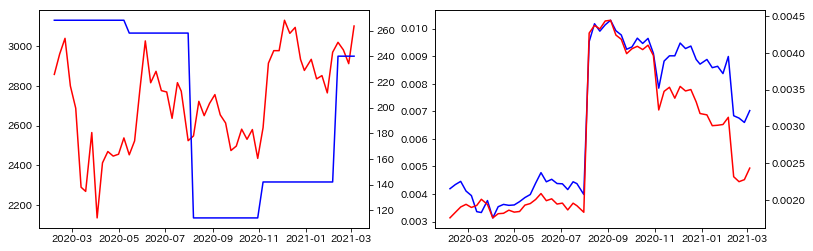

In [4]:
a=PER(7267)
a.main()

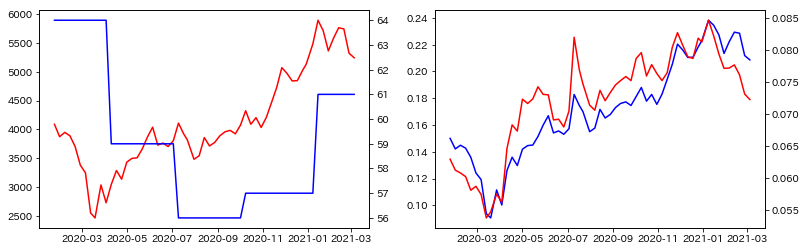

In [5]:
a=PER(6506)
a.main()

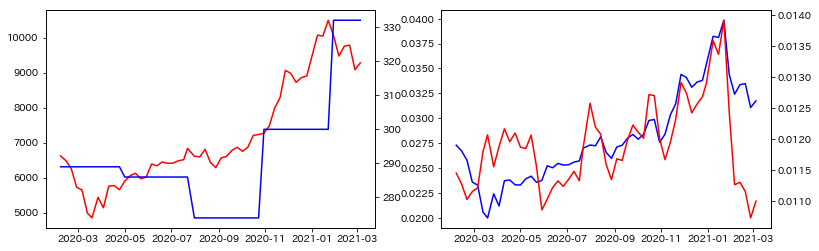

In [6]:
a=PER(6981)
a.main()

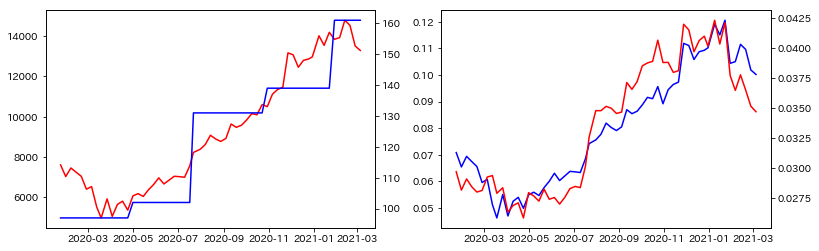

In [7]:
a=PER(6594)
a.main()

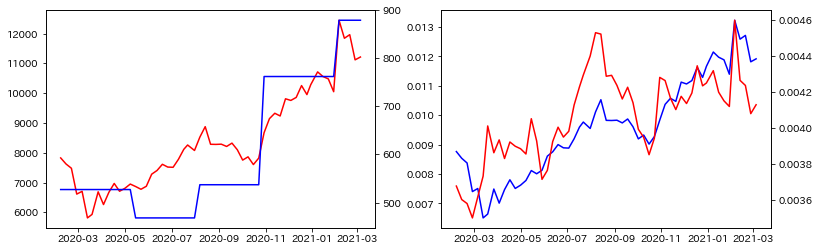

In [8]:
a=PER(6758)
a.main()

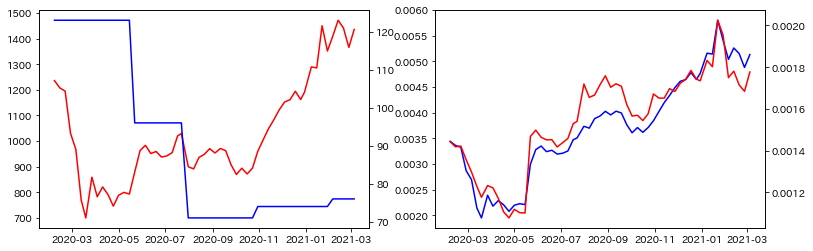

In [9]:
a=PER(6752)
a.main()

C:\Users\ShIzm\Anaconda3\lib\site-packages\ipykernel_launcher.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ShIzm\Anaconda3\lib\site-packages\ipykernel_launcher.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


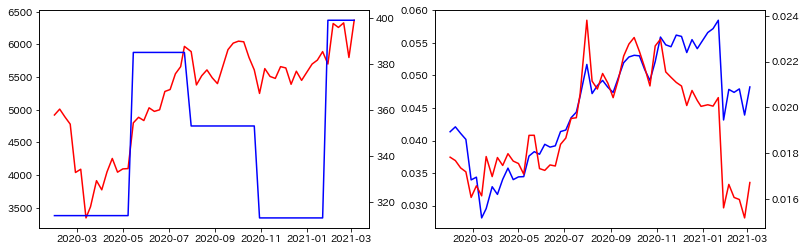

In [10]:
a=PER(6701)
a.main()

C:\Users\ShIzm\Anaconda3\lib\site-packages\ipykernel_launcher.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ShIzm\Anaconda3\lib\site-packages\ipykernel_launcher.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


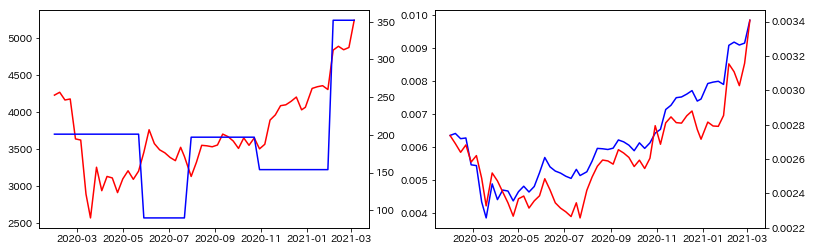

In [11]:
a=PER(6501)
a.main()

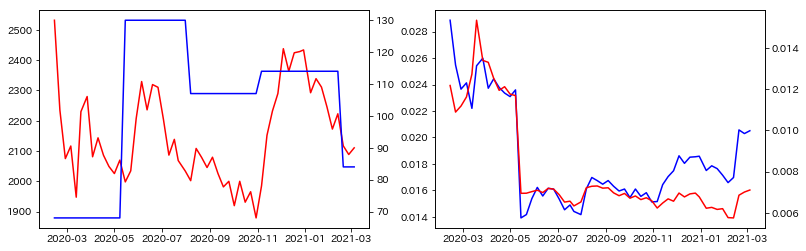

In [12]:
a=PER(2503)
a.main()

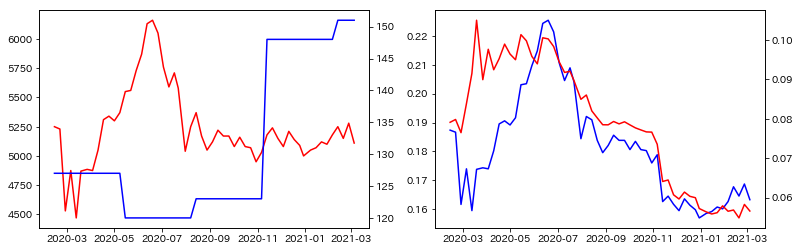

In [13]:
a=PER(2702)
a.main()

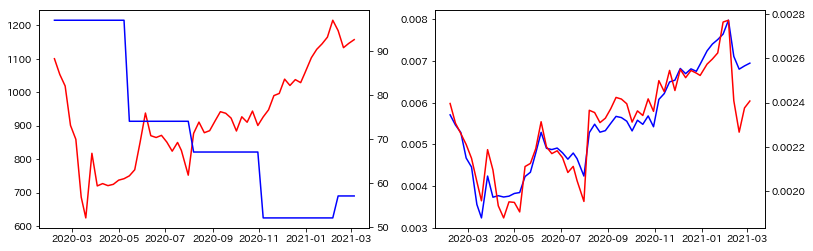

In [14]:
a=PER(3407)
a.main()

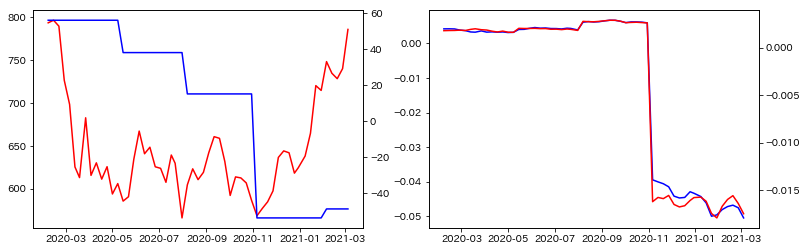

In [15]:
a=PER(4188)
a.main()

C:\Users\ShIzm\Anaconda3\lib\site-packages\ipykernel_launcher.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ShIzm\Anaconda3\lib\site-packages\ipykernel_launcher.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


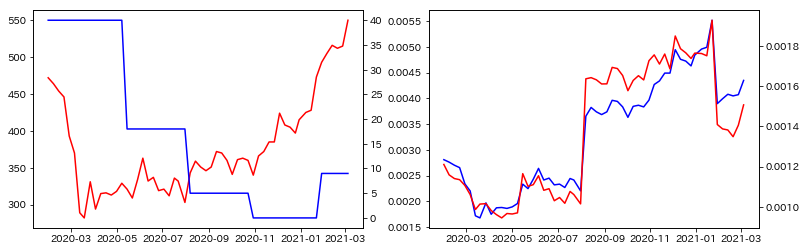

In [16]:
a=PER(4005)
a.main()

C:\Users\ShIzm\Anaconda3\lib\site-packages\ipykernel_launcher.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ShIzm\Anaconda3\lib\site-packages\ipykernel_launcher.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


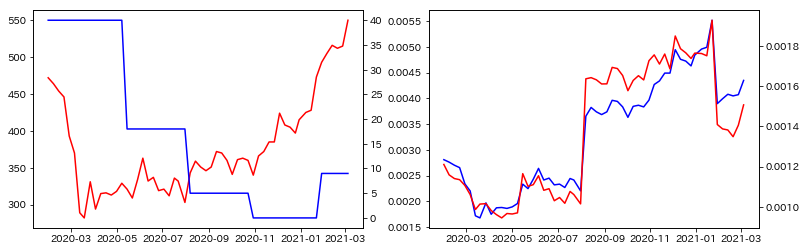

In [17]:
a=PER(4005)
a.main()

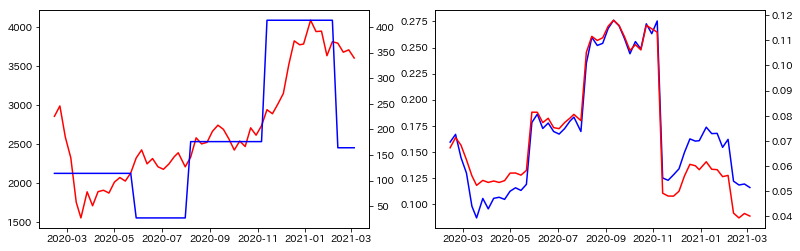

In [18]:
a=PER(5706)
a.main()

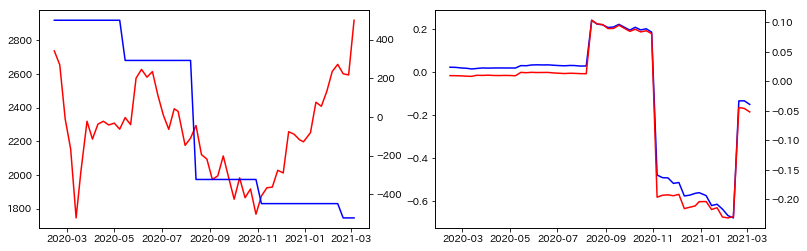

In [19]:
a=PER(4004)
a.main()